In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow.keras.backend as K
import sys
import datetime

from sificc_lib import AI, utils, Event, Simulation, root_files, DataModel
np.set_printoptions(precision=2, linewidth=85, suppress=True)

%matplotlib inline

In [2]:
# Check used versions
now = datetime.datetime.now()
print("Date-time           ", now)
print("Tf version:         ", keras.__version__)
print("Numpy version:      ", np.__version__)
print("Python              ", sys.executable)
print("Python version      ", sys.version)

Date-time            2021-07-30 14:47:46.576842
Tf version:          2.3.0-tf
Numpy version:       1.19.1
Python               /net/software_g4rt/anaconda3/envs/condaenv-sificcnn/bin/python
Python version       3.7.9 (default, Aug 31 2020, 12:42:55) 
[GCC 7.3.0]


In [3]:
%%time
# model name
model_name = 'model-2b-lsr-enough-repro'

shuffle_clusters = False

# load the training data
data = DataModel('data-enough-8cl-emax.npz', 
                 batch_size = 128, validation_percent = .05, test_percent = .1)

# append an extra dimention to the features since we are using convolutional layers
data.append_dim = True

# create an AI instance
ai = AI(data, model_name)

ai.weight_type = 2
ai.weight_pos_x = 2.5
ai.weight_pos_y = 1
ai.weight_pos_z = 2
ai.weight_energy = 1.5
ai.weight_e_cluster = 1
ai.weight_p_cluster = 1

# randomly shuffle the training data
#np.random.seed(888)
#ai.data.shuffle(only_train=False)

# shuffle the clusters within each event
if shuffle_clusters:
    ai.data.shuffle_training_clusters()

CPU times: user 2.31 s, sys: 339 ms, total: 2.65 s
Wall time: 2.65 s


In [4]:
# define and create the neural network architecture
ai.create_model(conv_layers=[128, 64], classifier_layers=[32], type_layers=[8], 
                pos_layers=[64,32], energy_layers=[32, 16], base_l2=.0001, limbs_l2=.0001)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 72, 1)]      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 8, 128)       1280        inputs[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 8, 64)        8256        conv_1[0][0]                     
__________________________________________________________________________________________________
flatting (Flatten)              (None, 512)          0           conv_2[0][0]                     
______________________________________________________________________________________________

In [5]:
%%time
# compile the ai
ai.compile_model(learning_rate=0.0003)

# define the learning rate scheduler for the training phase
def lr_scheduler(epoch):
    if epoch < 90:
        return .0003
    elif epoch < 160:
        return .0001
    elif epoch < 180:
        return .00003
    elif epoch < 190:
        return .00001
    else:
        return .000003
l_callbacks = [
    keras.callbacks.LearningRateScheduler(lr_scheduler),
]

CPU times: user 22.8 ms, sys: 1.95 ms, total: 24.8 ms
Wall time: 22.6 ms


In [6]:
%%time
#TRAINING
# start the training
#ai.train(epochs=200, shuffle=True, shuffle_clusters=shuffle_clusters, verbose=0, callbacks = l_callbacks)

CPU times: user 12 µs, sys: 3 µs, total: 15 µs
Wall time: 22.2 µs


In [7]:
# Load trained model
ai.load(model_name, optimizer=False)

In [8]:
# Weights of specified layers
#ai.model.layers[1].get_weights()

In [9]:
# Show all layers
ai.model.layers

In [10]:
# Get weights of convolutional layers
for layer in ai.model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
        # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

conv_1 (9, 1, 128)
conv_2 (1, 128, 64)


In [11]:
# Filter and biases of first conv (1D) layer
filters, biases = ai.model.layers[1].get_weights()

In [12]:
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

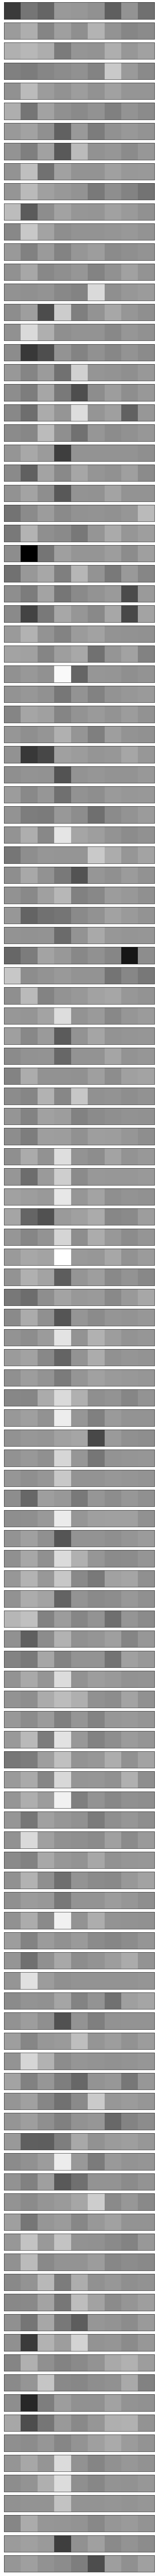

In [13]:
# Plotting filters of the convolutional layer

n_filters, ix = 128,1
fig1 = plt.figure(figsize=(10,128))
for i in range(n_filters):
    # get the filter
    f = filters[:, :, i]
    # plot each channel separately
    for j in range(1):
        ax = fig1.add_subplot(n_filters, 1, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        ff = f[:, j]
        f_expand = np.expand_dims(ff,axis=0)
        # plot filter channel in grayscale
        plt.imshow(f_expand, cmap='gray')
        plt.clim(0,1)
        ix += 1
plt.show()
plt.close()

# Nine filter channels per event
# Filters are applied to input data (features)
# Dark = small weights, light = larger weights

In [14]:
# Visualize feature maps
# Feature map: filters applied on corresponding input

for i in range(len(ai.model.layers)):
    layer = ai.model.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # summarize output shape
    print(i, layer.name, layer.output.shape)

1 conv_1 (None, 8, 128)
2 conv_2 (None, 8, 64)


In [15]:
# New model which predicts the outputs of the conv1D layr
model_conv_output = keras.models.Model(inputs=ai.model.inputs, outputs=ai.model.layers[1].output)

In [16]:
# Prediction on single event from test data set
feature_maps = model_conv_output.predict(ai.data.test_x[:1])
print('Shape of feature_maps: ')
feature_maps.shape

Shape of feature_maps: 


(1, 8, 128)

In [17]:
# Just some testing
# Remark: Predictions normalized
print(ai.predict(ai.data.get_features(0,1)))
print(ai.predict(ai.data.get_features(0,1), denormalize=True))
print(ai.predict(ai.data.get_features(1,2)))
print(ai.predict(ai.data.get_features(24,25)))
print(ai.data.get_features(24,25).shape)
print(ai.data.test_x[:1].shape)
print(ai.data.test_x[:,1].shape)

[[ 1.   -5.34 -7.06 -1.23  9.66  9.84  2.15  5.64 -1.64]]
[[  1.     0.2    0.75 204.6   19.84  21.37 395.46  15.6   -2.48]]
[[  0.    50.08   2.89  -3.69 -11.23  -0.03  -0.96  -3.46 -16.86]]
[[ 1.    0.77  7.28 -0.92 12.74 -4.73  5.    4.9   3.84]]
(1, 72, 1)
(1, 72, 1)
(65668, 1)


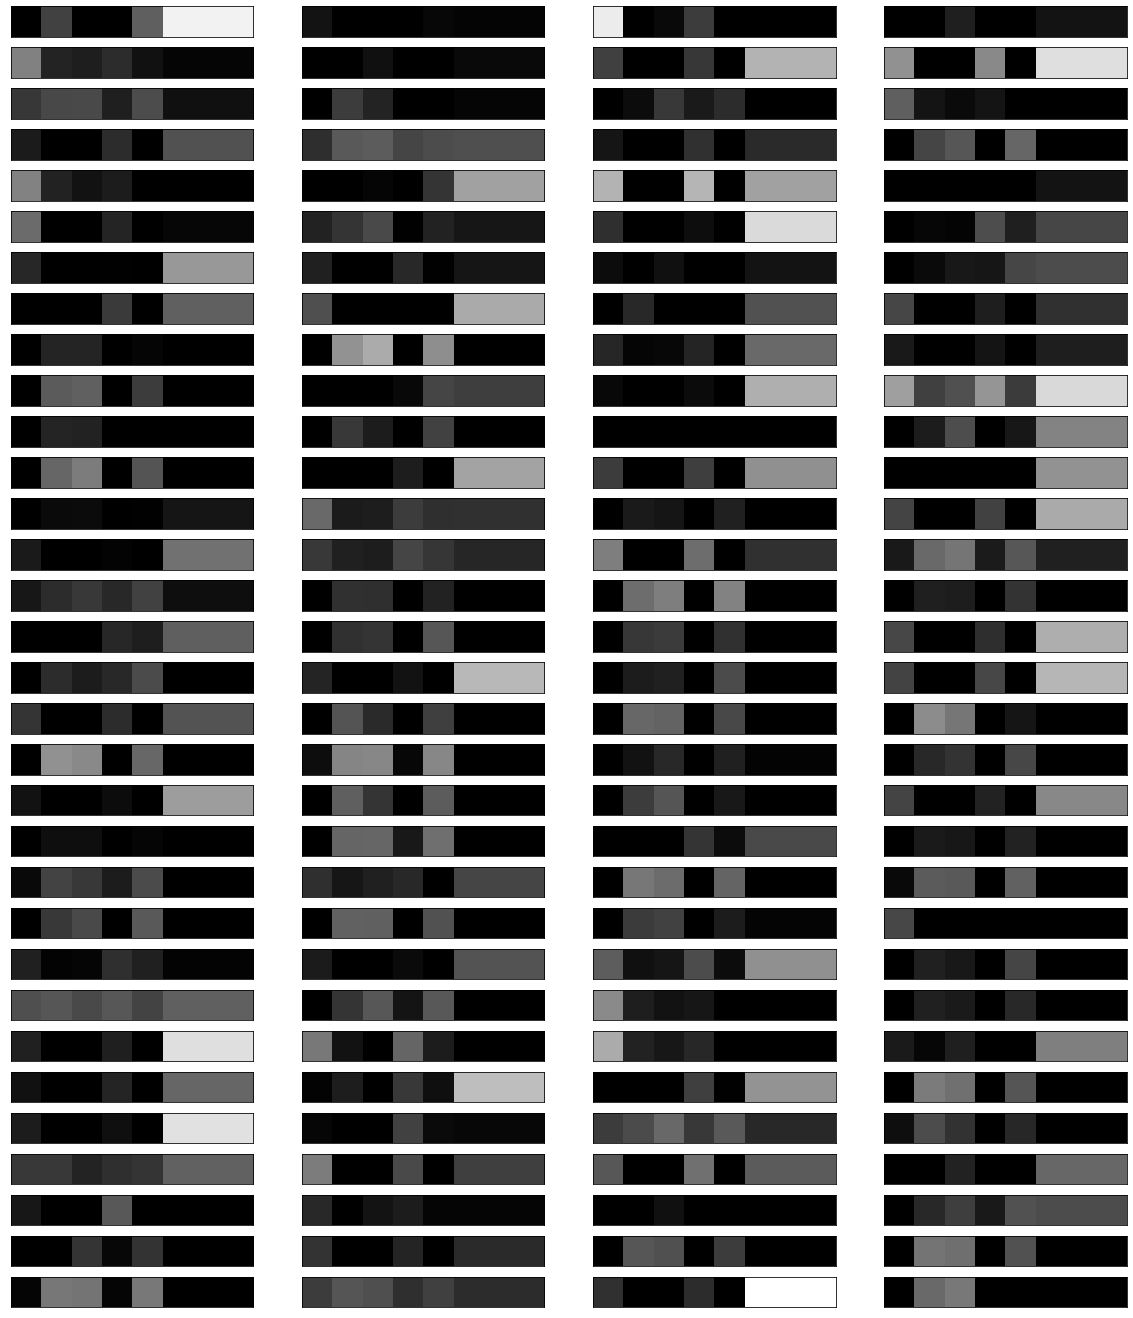

In [18]:
# Feature output maps of first convolutional layer, for a given event
square1 = 32
square2 = 4
ix = 1
fig1 = plt.figure(figsize=(20,24))
for _ in range(square1):
    for _ in range(square2):
        # specify subplot and turn of axis
        ax = fig1.add_subplot(square1, square2, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        #print(feature_maps[0, :, ix-1])
        fm_expand = np.expand_dims(feature_maps[0, :, ix-1], axis=0)
        plt.imshow(fm_expand, cmap='gray')
        plt.clim(np.amin(feature_maps[0]),np.amax(feature_maps[0]))
        ix += 1
        # show the figure
plt.show()
# Feature map visualization for prediction of trained model on test data point

In [19]:
# Prediction on training data set
# New model which predicts the outputs of the conv1D layer
feature_maps_train = model_conv_output.predict(ai.data.get_features(0,1))

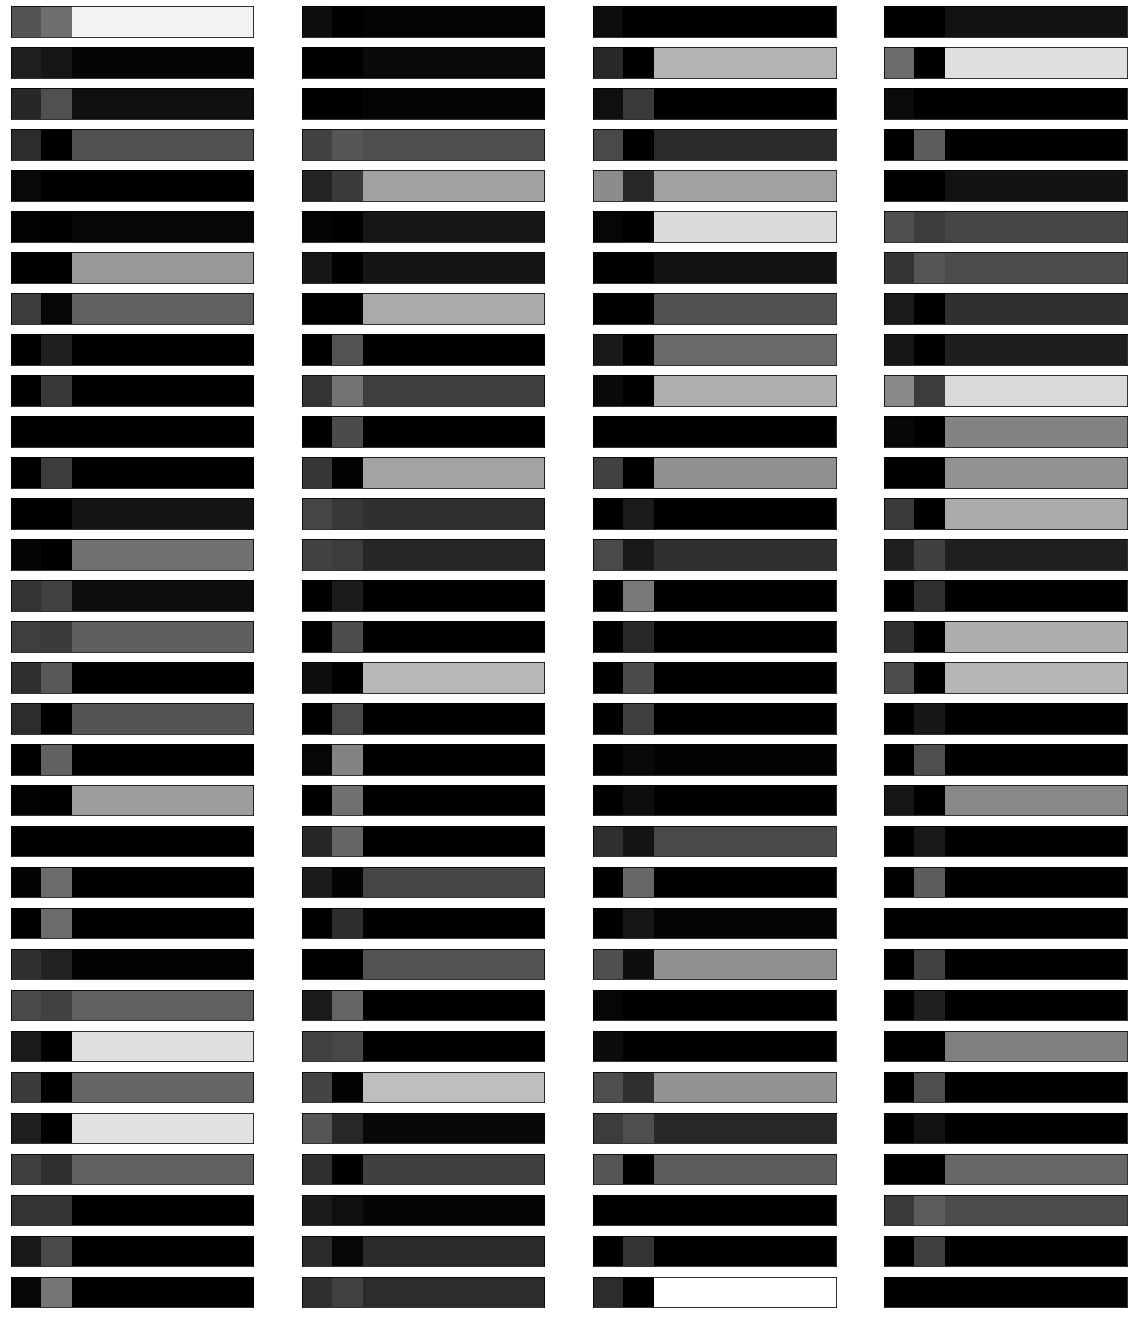

In [20]:
# Feature output maps of first convolutional layer, for a given event
square1 = 32
square2 = 4
ix = 1
fig1 = plt.figure(figsize=(20,24))
for _ in range(square1):
    for _ in range(square2):
        # specify subplot and turn of axis
        ax = fig1.add_subplot(square1, square2, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        #print(feature_maps[0, :, ix-1])
        fm_expand = np.expand_dims(feature_maps_train[0, :, ix-1], axis=0)
        plt.imshow(fm_expand, cmap='gray')
        plt.clim(np.amin(feature_maps_train[0]),np.amax(feature_maps_train[0]))
        ix += 1

plt.show()

# Feature map for prediction with trained model 
# on training data set data point
# Eight channels
    # No of clusters, Cl energy, Cluster energy uncertainty
    # Cl pos x y z , Cl pos uncertainty x y z 